# Pytorch Implementation 
Use Resnet50 epoch-15 to train ImageWoof
Visualize the training by GRAD_CAM

The transfer learning is adapted from the pytorch tutorial
The GRAD_CAM implementation is based on 
Paper https://arxiv.org/abs/1610.02391 
And tutorials given on others on Github

Copyright (c) Yanting Jin, 21th Nov, 2020.


In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time
import os
import copy

import cv2 
import sys


plt.ion()   # interactive mode

# Load data

Transform the image and normalize it


In [ ]:
# Load Imagewoof dataset from fastai 
! [ -e /content ] && pip install -Uqq fastai  
from fastai.vision.all import *
path = untar_data(URLs.IMAGEWOOF_320)

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 


In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/imagewoof2-320/val'),Path('/root/.fastai/data/imagewoof2-320/train')]

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
              
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:

dataset_sizes


{'train': 9025, 'val': 3929}

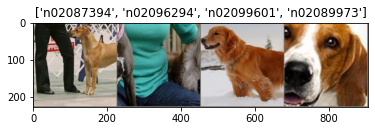

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

ConvNet as fixed feature extractor
----------------------------------

Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset.

Once you extract the CNN codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.

You can read more about this in the documentation here:

<https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>

<https://cs231n.github.io/transfer-learning/>




In [ ]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # freeze the CNN code and prevent backpropagation  

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=15)

Epoch 0/4
----------
train Loss: 0.9764 Acc: 0.6793
val Loss: 0.1608 Acc: 0.9476

Epoch 1/4
----------
train Loss: 0.8436 Acc: 0.7336
val Loss: 0.1674 Acc: 0.9496

Epoch 2/4
----------
train Loss: 0.8130 Acc: 0.7457
val Loss: 0.1674 Acc: 0.9463

Epoch 3/4
----------
train Loss: 0.8108 Acc: 0.7491
val Loss: 0.1536 Acc: 0.9514

Epoch 4/4
----------
train Loss: 0.8454 Acc: 0.7422
val Loss: 0.1670 Acc: 0.9519

Training complete in 10m 54s
Best val Acc: 0.951896


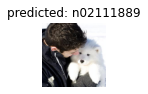

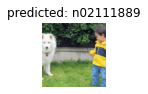

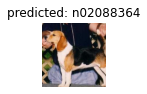

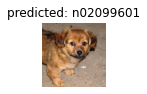

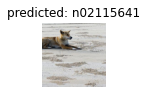

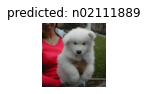

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

#Save model

In [ ]:
dir = '/content/TL_RestNet50_conv.pth'
torch.save(model_ft.state_dict(), dir)

#Visualize photos with top loss 

#Visualize by GRAD-CAM

In [ ]:
class FeatureExtractor():
    """ Class for extracting activations and 
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.model_features = model.features
        self.target_layers = target_layers
        self.gradients = list()

    def save_gradient(self, grad):
        self.gradients.append(grad)
    def get_gradients(self):
        return self.gradients

    def __call__(self, x):
        target_activations = list()
        self.gradients = list()
        for name, module in self.model_features._modules.items(): #遍历的方式遍历网络的每一层
            x = module(x) #input 会经过遍历的每一层
            if name in self.target_layers: #设个条件，如果到了你指定的层， 则继续
                x.register_hook(self.save_gradient) #利用hook来记录目标层的梯度
                target_activations += [x] #这里只取得目标层的features
        x = x.view(x.size(0), -1) #reshape成 全连接进入分类器
        x = self.model.classifier(x)#进入分类器
        return target_activations, x,


In [ ]:
class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)
        
        return target_activations, x

In [ ]:
def preprocess_image(img):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]

    preprocessed_img = img.copy()[:, :, ::-1]
    for i in range(3):
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] - means[i]
        preprocessed_img[:, :, i] = preprocessed_img[:, :, i] / stds[i]
   
    preprocessed_img = \
        np.ascontiguousarray(np.transpose(preprocessed_img, (2, 0, 1)))
    preprocessed_img = torch.from_numpy(preprocessed_img) 
    preprocessed_img.unsqueeze_(0)
    input = preprocessed_img.requires_grad_(True)
    return input

In [ ]:
def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    cv2.imwrite("cam.jpg", np.uint8(255 * cam))

In [ ]:
import cv2

def superimpose_heatmap(heatmap, img):
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.006 + inv_norm(img[0]).permute(1,2,0)
    
    return superimposed_img

def get_grad_cam(net, img):
    net.eval()
    pred = net(img)
    pred[:,pred.argmax(dim=1)].backward()
    gradients = net.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = net.get_activations(img).detach()
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    
    return torch.Tensor(superimpose_heatmap(heatmap, img).permute(2,0,1))